<a href="https://colab.research.google.com/github/yeshwanthkonk/TelecomChurnPrediction_HybridModel_UVIC_503/blob/main/Churn_Prediction_Dimentionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# load dataset from CSV
df = pd.read_csv('/content/drive/MyDrive/Collab_Files/Churn_Prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_LR = df.copy()
X = df.drop(columns="Churn")
y = df["Churn"]
y = y.map({'Yes': 1, 'No': 0})

Mounted at /content/drive


## Process Data

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

def encode_data(df, df_y, ordinal):
  # Drop extraneous columns
  df = df.drop(columns=[c for c in ['Phone','Churn','customerID'] if c in df.columns])

  # Convert false objects to float
  df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

  if ordinal:
    df["Contract"] = df["Contract"].map({"Month-to-month": 0, "One year": 1, "Two year": 2})

  # Drop Missing Value + and drop those rows for labels
  original_index = df.index
  df = df.dropna()
  dropped_idx = original_index.difference(df.index)
  df_y = df_y.drop(index=dropped_idx)

  # Get categorical columns (excluding customerID which is just an identifier)
  categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

  # Create a copy of the dataframe for encoding and remove null data
  df_encoded = df.copy()

  # Method 1: Label Encoding for binary categorical variables
  binary_categorical = []
  multi_categorical = []

  # Identify binary vs multi-category variables
  for col in categorical_cols:
      unique_values = df[col].nunique()
      if unique_values == 2:
          binary_categorical.append(col)
      else:
          multi_categorical.append(col)

  # Apply Label Encoding to binary categorical variables
  label_encoders = {}
  for col in binary_categorical:
      le = LabelEncoder()
      df_encoded[col] = le.fit_transform(df[col])
      label_encoders[col] = le

  # Method 2: One-Hot Encoding for multi-categorical variables
  if multi_categorical:
      df_encoded = pd.get_dummies(df_encoded, columns=multi_categorical, prefix=multi_categorical, drop_first=True)

  bool_cols = df_encoded.select_dtypes(include='bool').columns
  df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

  return df_encoded, df_y

def scale_data(train_np, test_np):
  # Apply Min-Max scaling to range [-1, 1]
  scaler = MinMaxScaler(feature_range=(-1, 1))
  train_scaled_np = scaler.fit_transform(train_np)
  test_scaled_np = scaler.transform(test_np)

  return train_scaled_np, test_scaled_np

X, y = encode_data(X, y, False)
X = X.values
y = y.values

## UMAP Dimentionality Reduction
By using UMAP dimentionality reduction we can plot our dataset in 2D, which will give us insight into how seperable the classes are.

In [6]:
import umap
import matplotlib.pyplot as plt

# Initialize UMAP reducer
reducer = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.5, random_state=42)

# Fit and transform X to 2D
X_umap = reducer.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


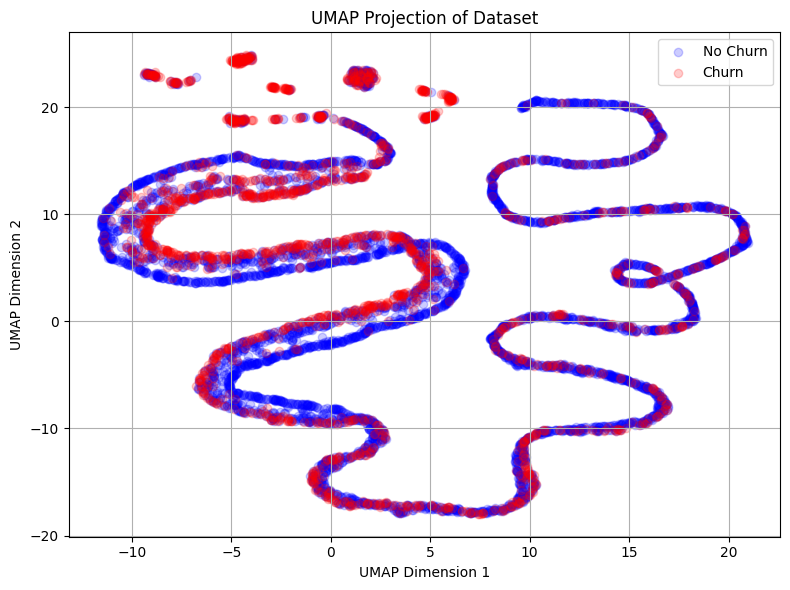

In [7]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[y == 0, 0], X_umap[y == 0, 1], c='blue', label='No Churn', alpha=0.2)
plt.scatter(X_umap[y == 1, 0], X_umap[y == 1, 1], c='red', label='Churn', alpha=0.2)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection of Dataset')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()